In [17]:
import numpy as np
import pandas as pd

In [18]:
df = pd.read_csv("results.csv")
df

,program,threads,steps,size,time(s)
0,mpi,1,100000,1000,2943.466269
1,mpi,1,100000,100,416.400007
2,mpi,1,100000,2000,3657.369837
3,mpi,1,10000,1000,139.541523
4,mpi,1,10000,100,4.482736
...,...,...,...,...,...
139,serial,8,1000,100,0.100000
140,serial,8,1000,2000,48.920000
141,serial,8,100,1000,1.160000
142,serial,8,100,100,0.010000


In [19]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mpi_subfigures_square(data_dict: dict[int, pd.DataFrame]):
    num_plots = len(data_dict)
    ncols = math.ceil(math.sqrt(num_plots))
    nrows = math.ceil(num_plots / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
    axes = axes.flatten()  # Make it easier to index

    for ax, (threads, df) in zip(axes, data_dict.items()):
        avg_df = df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
        sns.lineplot(data=avg_df, x='steps', y='time(s)', hue='size', marker='o', ax=ax)
        ax.set_title(f'{threads} Workers')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Time (s)')
        ax.grid(True)

    # Turn off any unused axes
    for ax in axes[num_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


In [20]:
def get_mpi_df(df: pd.DataFrame, threads: int) -> pd.DataFrame:
    return df.loc[(df["program"] == "mpi") & (df["threads"] == threads)]


In [21]:
mpi_df = {k: get_mpi_df(df, k) for k in [1, 2, 4, 8, 16, 32]}
len(mpi_df)

6

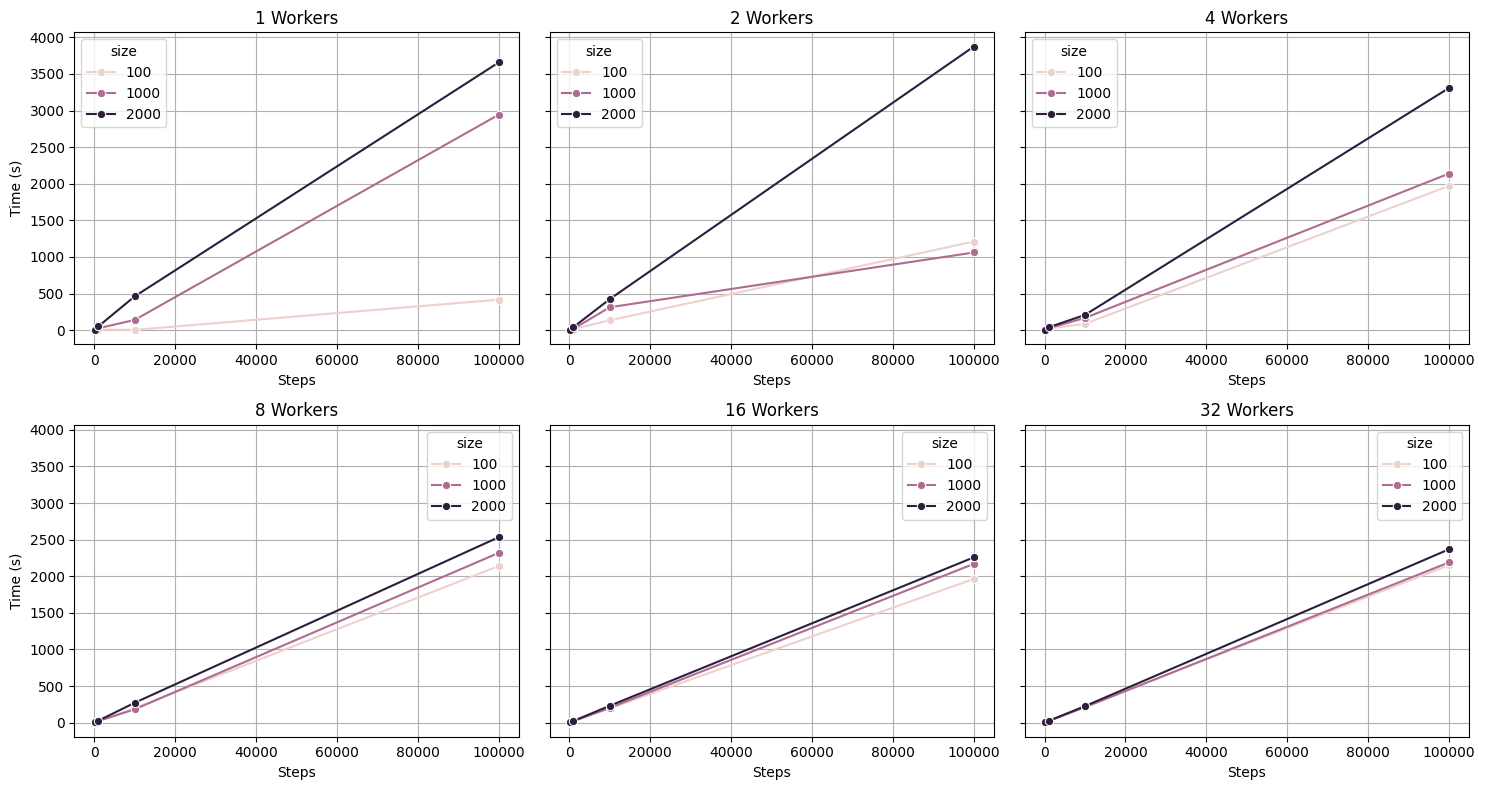

In [22]:
plot_mpi_subfigures_square(mpi_df)

In [49]:
def plot_mpi_with_serial(data_dict: dict[int, pd.DataFrame], serial_df: pd.DataFrame):
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    num_plots = len(data_dict)
    ncols = math.ceil(math.sqrt(num_plots))
    nrows = math.ceil(num_plots / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharey=True)
    axes = axes.flatten()

    # Add source labels
    serial_df = serial_df.copy()
    serial_df['source'] = 'Serial'
    serial_avg_df = serial_df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
    serial_avg_df['source'] = 'Serial'

    # Determine consistent size order and palette
    all_sizes = sorted(set(serial_avg_df['size']) | {s for df in data_dict.values() for s in df['size'].unique()})
    palette = sns.color_palette(n_colors=len(all_sizes))
    size_color_map = dict(zip(all_sizes, palette))

    for ax, (threads, mpi_df) in zip(axes, data_dict.items()):
        mpi_df = mpi_df.copy()
        mpi_df['source'] = 'MPI'
        mpi_avg_df = mpi_df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
        mpi_avg_df['source'] = 'MPI'

        combined_df = pd.concat([mpi_avg_df, serial_avg_df], ignore_index=True)

        sns.lineplot(
            data=combined_df,
            x='steps', y='time(s)',
            hue='size',
            style='source',
            markers=True,
            dashes={'MPI': '', 'Serial': (2, 2)},
            palette=size_color_map,
            ax=ax
        )

        ax.set_title(f'{threads} Workers')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Time (s)')
        ax.grid(True)

    for ax in axes[num_plots:]:
        ax.set_visible(False)

    # Global legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title='Size / Source')

    plt.tight_layout()
    plt.show()


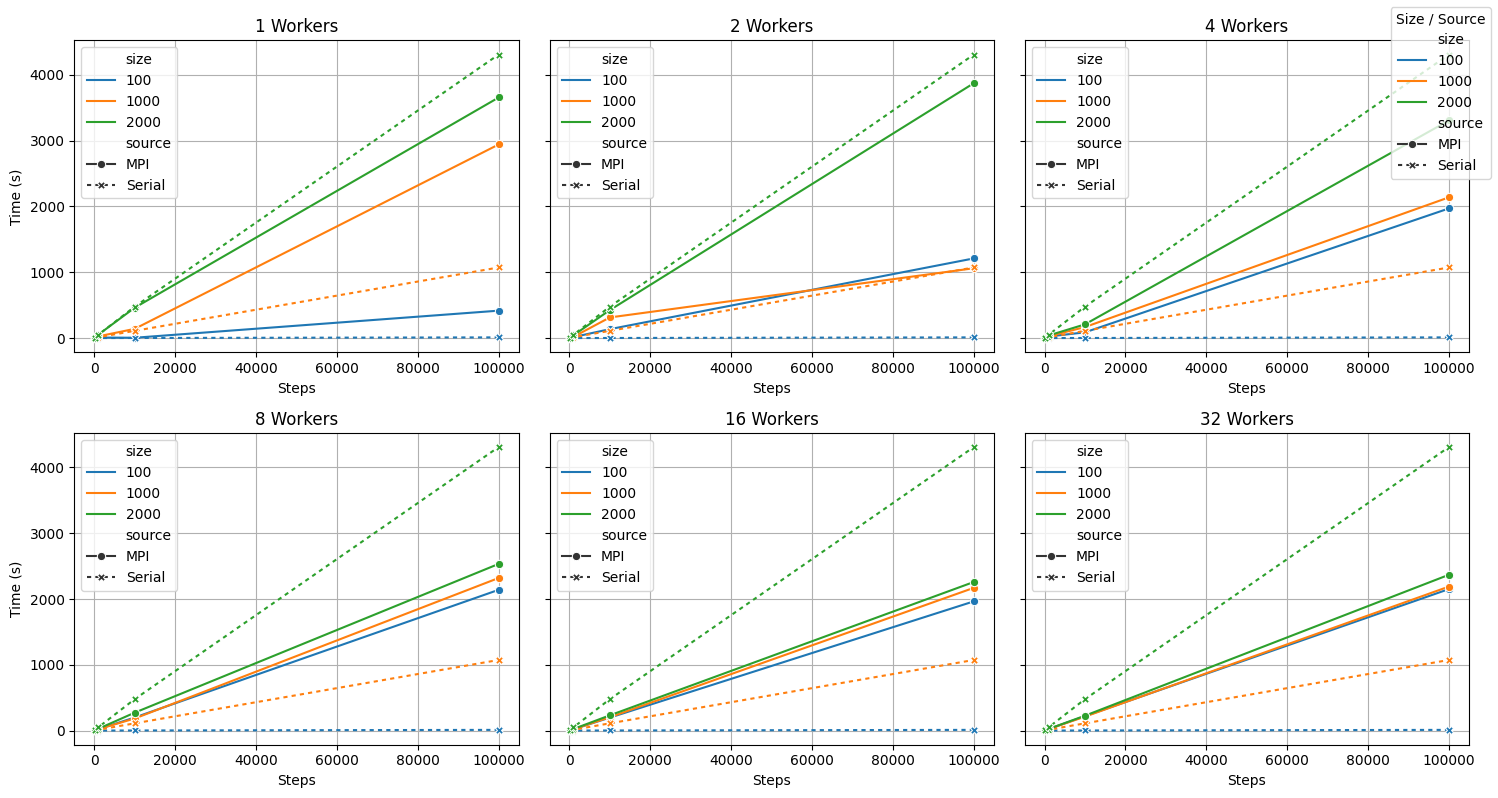

In [50]:
serial_df = df[df["program"] == "serial"]
plot_mpi_with_serial(mpi_df, serial_df)

In [77]:
def compute_speedup_from_dict(mpi_dict: dict[int, pd.DataFrame], serial_df: pd.DataFrame) -> pd.DataFrame:
    # Compute average serial times
    serial_avg = serial_df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
    serial_avg = serial_avg.rename(columns={'time(s)': 'serial_time'})

    all_speedups = []

    for workers, mpi_df in mpi_dict.items():
        mpi_avg = mpi_df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
        mpi_avg = mpi_avg.rename(columns={'time(s)': 'mpi_time'})
        mpi_avg['threads'] = workers

        # Merge with serial times
        merged = pd.merge(mpi_avg, serial_avg, on=['steps', 'size'])
        merged['speedup'] = merged['serial_time'] / merged['mpi_time']
        all_speedups.append(merged[['threads', 'steps', 'size', 'speedup']])

    return pd.concat(all_speedups, ignore_index=True)

def compute_speedup_from_baseline_dict(mpi_dict: dict[int, pd.DataFrame]) -> pd.DataFrame:
    results = []

    # Use the lowest MPI rank as the baseline
    baseline_rank = min(mpi_dict.keys())
    baseline_time = mpi_dict[baseline_rank]["time(s)"].mean()

    for rank, df in sorted(mpi_dict.items()):
        mean_time = df["time(s)"].mean()
        speedup = baseline_time / mean_time
        results.append({
            "mpi_ranks": rank,
            "mean_time": mean_time,
            "speedup": speedup
        })

    return pd.DataFrame(results)

def plot_speedup(speedup_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=speedup_df,
        x='threads',
        y='speedup',
        hue='size',
        marker='o',
        palette='viridis'
    )

    # Bold red horizontal line at speedup = 1
    plt.axhline(y=1, linestyle='--', color='red', linewidth=2, label='Serial Baseline')

    plt.title('MPI Speedup compared with serial')
    plt.xlabel('Number of Workers')
    plt.ylabel('Speedup')
    plt.grid(True)
    plt.legend(title='Size', loc='best')
    plt.tight_layout()
    plt.show()

def plot_baseline_speedup(speedup_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))

    sns.lineplot(
        data=speedup_df,
        x='mpi_ranks', 
        y='speedup',
        marker='o',
        color='blue',
        linewidth=2
    )

    plt.axhline(y=1, linestyle='--', color='red', linewidth=2, label='Baseline Speedup = 1')

    plt.title('MPI Speedup Relative to Baseline (1 MPI Rank × 4 Threads)')
    plt.xlabel('MPI Ranks')
    plt.ylabel('Speedup')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


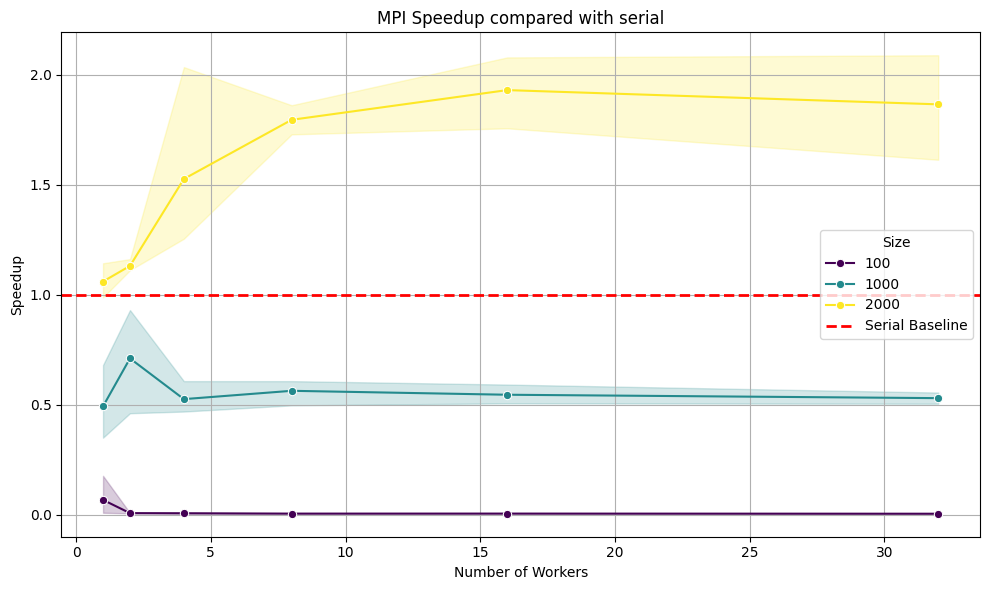

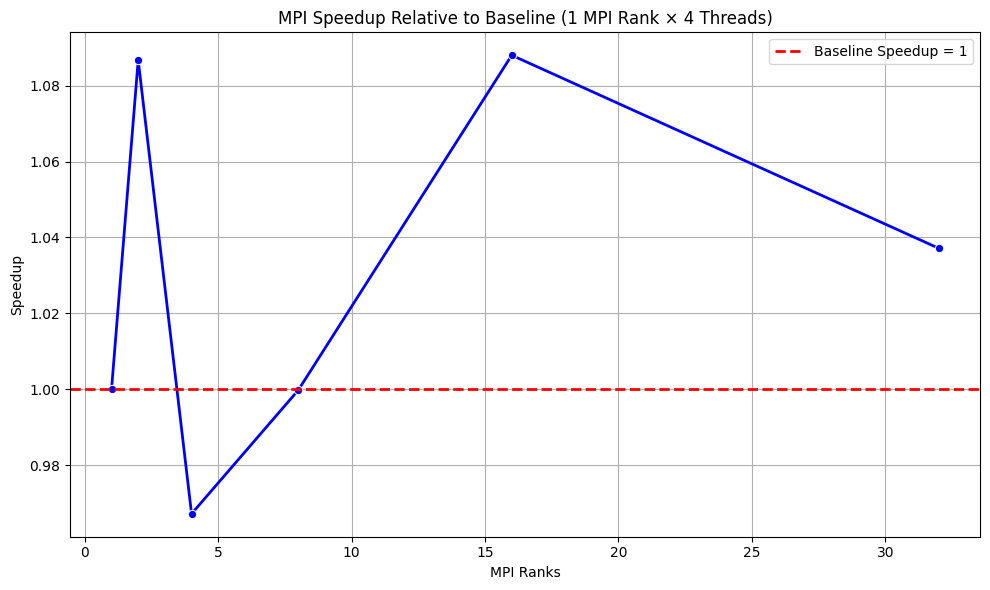

In [78]:
speedups = compute_speedup_from_dict(mpi_df, serial_df)
plot_speedup(speedups)
baseline_speedups = compute_speedup_from_baseline_dict(mpi_df)
plot_baseline_speedup(baseline_speedups)

In [27]:
def compute_speedup_multi_source(
    source_dict: dict[str, dict[int, pd.DataFrame]],  # e.g., {'mpi': {1: df, 2: df}, 'omp': {...}}
    serial_df: pd.DataFrame
) -> pd.DataFrame:
    # Compute average serial times
    serial_avg = serial_df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
    serial_avg = serial_avg.rename(columns={'time(s)': 'serial_time'})

    all_speedups = []

    for source, thread_dict in source_dict.items():
        for threads, df in thread_dict.items():
            avg_df = df.groupby(['steps', 'size'])['time(s)'].mean().reset_index()
            avg_df = avg_df.rename(columns={'time(s)': 'runtime'})
            avg_df['threads'] = threads
            avg_df['source'] = source

            merged = pd.merge(avg_df, serial_avg, on=['steps', 'size'])
            merged['speedup'] = merged['serial_time'] / merged['runtime']
            all_speedups.append(merged[['source', 'threads', 'steps', 'size', 'speedup']])

    return pd.concat(all_speedups, ignore_index=True)


In [28]:
def plot_speedup_multi_source(speedup_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))

    # Add a combined label for hue, and style based on source
    speedup_df['label'] = speedup_df['source'] + ' - ' + speedup_df['size'].astype(str)

    sns.lineplot(
        data=speedup_df,
        x='threads',
        y='speedup',
        hue='label',           # separate line for each source+size
        style='source',        # dashed vs solid based on 'source'
        dashes={'mpi': '', 'omp': (4, 2)},  # solid for mpi, dashed for omp
        markers=True
    )

    plt.title('Speedup (MPI & OMP)')
    plt.xlabel('Number of Workers (Threads in OMP)')
    plt.ylabel('Speedup')
    plt.grid(True)
    plt.legend(title='Source - Size')
    plt.tight_layout()
    plt.show()


In [29]:
df = pd.read_csv("results-joined.csv")

In [30]:
source_dict = {}

for source in df['program'].unique():
    if source == 'serial':
        continue
    source_data = df[df['program'] == source]
    threads_group = {
        threads: group_df
        for threads, group_df in source_data.groupby('threads')
    }
    source_dict[source] = threads_group

In [31]:
source_dict.keys()

dict_keys(['mpi', 'omp'])

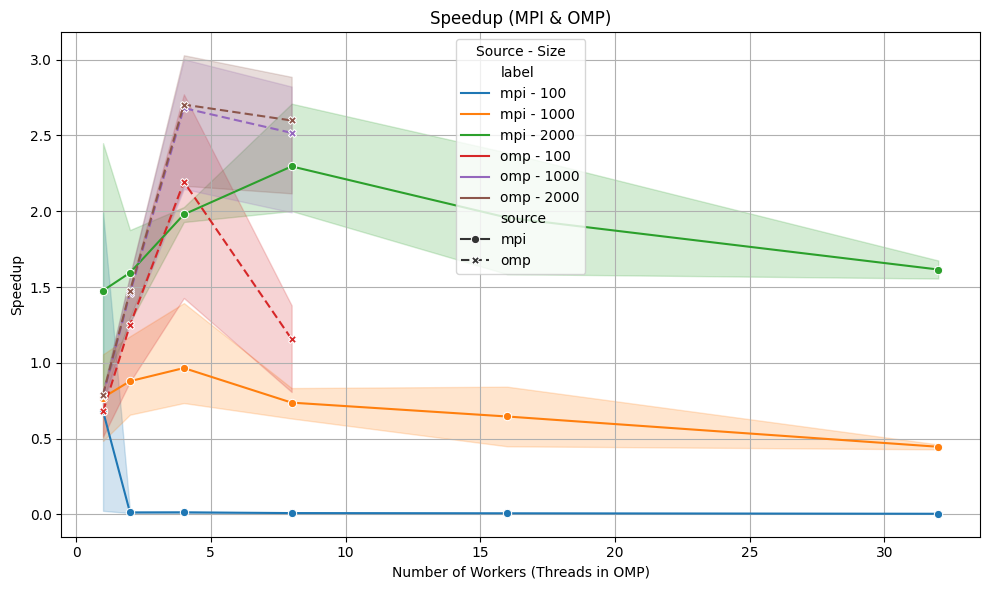

In [32]:
speedup_df = compute_speedup_multi_source(source_dict, serial_df)
plot_speedup_multi_source(speedup_df)

In [79]:
def compute_overhead_percentage(mpi_Dict: dict[int, pd.DataFrame], threads_per_rank: int = 4) -> pd.DataFrame:
    results = []

    # Use the smallest MPI rank as baseline
    baseline_rank = min(mpi_Dict.keys())
    baseline_time = mpi_Dict[baseline_rank]["time(s)"].mean()
    baseline_cores = baseline_rank * threads_per_rank

    for rank, df in sorted(mpi_Dict.items()):
        mean_time = df["time(s)"].mean()
        total_cores = rank * threads_per_rank

        ideal_time = baseline_time / total_cores
        overhead = mean_time - ideal_time
        overhead_percent = (overhead / mean_time) * 100

        results.append({
            "mpi_ranks": rank,
            "mean_time": mean_time,
            "ideal_time": ideal_time,
            "overhead(s)": overhead,
            "overhead(%)": overhead_percent
        })

    return pd.DataFrame(results)

In [80]:
def compute_efficiency(mpi_Dict: dict[int, pd.DataFrame], threads_per_rank: int = 4) -> pd.DataFrame:
    results = []

    baseline_rank = min(mpi_Dict.keys())
    baseline_time = mpi_Dict[baseline_rank]["time(s)"].mean()

    for rank, df in sorted(mpi_Dict.items()):
        mean_time = df["time(s)"].mean()
        total_cores = rank * threads_per_rank
        speedup = baseline_time / mean_time
        efficiency = speedup / total_cores

        results.append({
            "mpi_ranks": rank,
            "mean_time": mean_time,
            "speedup": speedup,
            "efficiency": efficiency
        })

    return pd.DataFrame(results)


In [83]:
def plot_overhead(overhead_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=overhead_df,
        x='mpi_ranks',
        y='overhead(%)',
        marker='o',
        color='darkorange',
        linewidth=2
    )

    plt.title('Parallel Overhead Percentage vs MPI Ranks')
    plt.xlabel('MPI Ranks')
    plt.ylabel('Overhead (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_efficiency(efficiency_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=efficiency_df,
        x='mpi_ranks',
        y='efficiency',
        marker='o',
        color='green',
        linewidth=2
    )

    plt.title('Parallel Efficiency vs MPI Ranks')
    plt.xlabel('MPI Ranks')
    plt.ylabel('Efficiency (Speedup / Cores)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


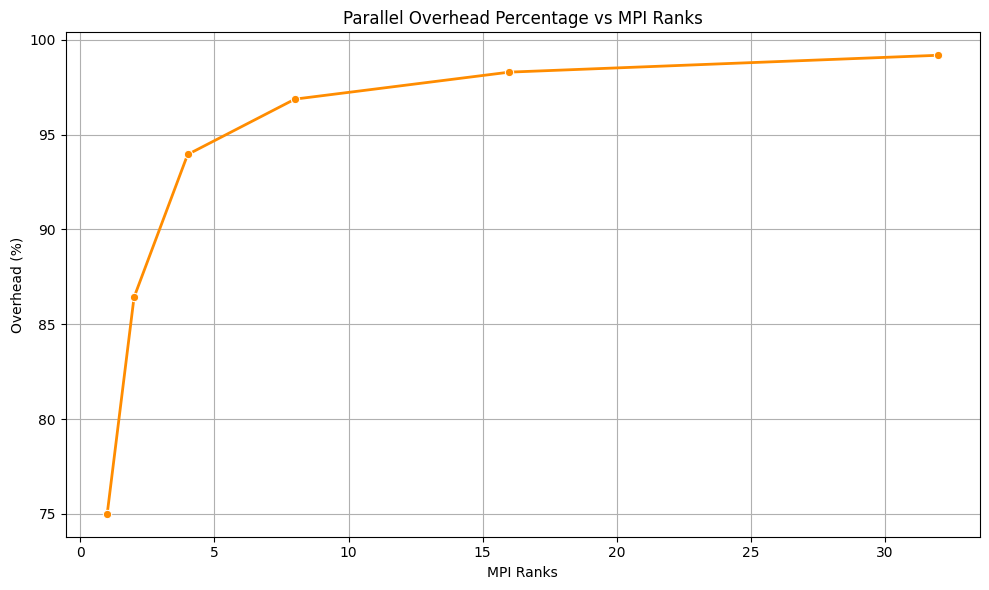

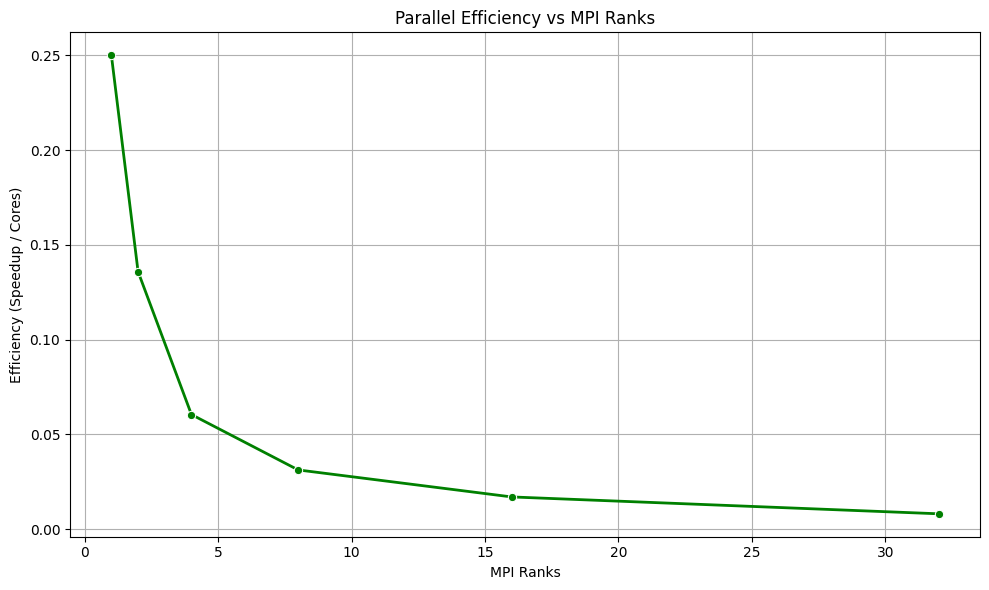

In [85]:

overhead_df = compute_overhead_percentage(mpi_df)
efficiency_df = compute_efficiency(mpi_df)

plot_overhead(overhead_df)
plot_efficiency(efficiency_df)


In [ ]:
def compute_metrics_by_size(mpi_Dict: dict[int, pd.DataFrame], threads_per_rank: int = 4) -> pd.DataFrame:
    import pandas as pd

    records = []

    # Step 1: Flatten into a single DataFrame with 'mpi_ranks' added
    for rank, df in mpi_Dict.items():
        df = df.copy()
        df["mpi_ranks"] = rank
        records.append(df)

    all_data = pd.concat(records, ignore_index=True)

    # Step 2: Group by size and mpi_ranks, compute mean time
    grouped = all_data.groupby(["size", "mpi_ranks"])["time(s)"].mean().reset_index(name="mean_time")
    grouped["cores"] = grouped["mpi_ranks"] * threads_per_rank

    # Step 3: Compute baseline times per size (mpi_ranks == min rank for each size)
    baseline_times = grouped.groupby("size").apply(lambda g: g[g["mpi_ranks"] == g["mpi_ranks"].min()]["mean_time"].values[0])
    baseline_times = baseline_times.to_dict()  # size -> baseline_time

    # Step 4: Compute speedup, efficiency, overhead
    metrics = []
    for _, row in grouped.iterrows():
        size = row["size"]
        rank = row["mpi_ranks"]
        time = row["mean_time"]
        cores = row["cores"]
        baseline_time = baseline_times[size]

        speedup = baseline_time / time
        ideal_time = baseline_time / cores
        overhead = time - ideal_time
        overhead_percent = (overhead / time) * 100
        efficiency = speedup / cores

        metrics.append({
            "size": size,
            "mpi_ranks": rank,
            "cores": cores,
            "mean_time": time,
            "speedup": speedup,
            "efficiency": efficiency,
            "overhead(s)": overhead,
            "overhead(%)": overhead_percent
        })

    return pd.DataFrame(metrics)


In [93]:
def plot_overhead_by_size(metrics_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=metrics_df,
        x='mpi_ranks',
        y='overhead(%)',
        hue='size',
        marker='o',
        palette='viridis'
    )

    plt.title('Parallel Overhead (%) by Problem Size')
    plt.xlabel('MPI Ranks')
    plt.ylabel('Overhead (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Size')
    plt.show()


In [94]:
def plot_efficiency_by_size(metrics_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=metrics_df,
        x='mpi_ranks',
        y='efficiency',
        hue='size',
        marker='o',
        palette='viridis'
    )

    plt.title('Parallel Efficiency by Problem Size')
    plt.xlabel('MPI Ranks')
    plt.ylabel('Efficiency')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Size')
    plt.show()


In [99]:
def plot_speedup_by_size(metrics_df: pd.DataFrame):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=metrics_df,
        x='mpi_ranks',
        y='speedup',
        hue='size',
        marker='o',
        palette='viridis'
    )

    plt.axhline(y=1, linestyle='--', color='red', linewidth=2, label='Baseline Speedup = 1')

    plt.title('Speedup by Problem Size')
    plt.xlabel('MPI Ranks')
    plt.ylabel('Speedup')
    plt.grid(True)
    plt.legend(title='Size')
    plt.tight_layout()
    plt.show()


/var/folders/k6/zj7bjk4s5jb69l8mq6lfgqw80000gn/T/ipykernel_6663/55401403.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline_times = grouped.groupby("size").apply(lambda g: g[g["mpi_ranks"] == g["mpi_ranks"].min()]["mean_time"].values[0])


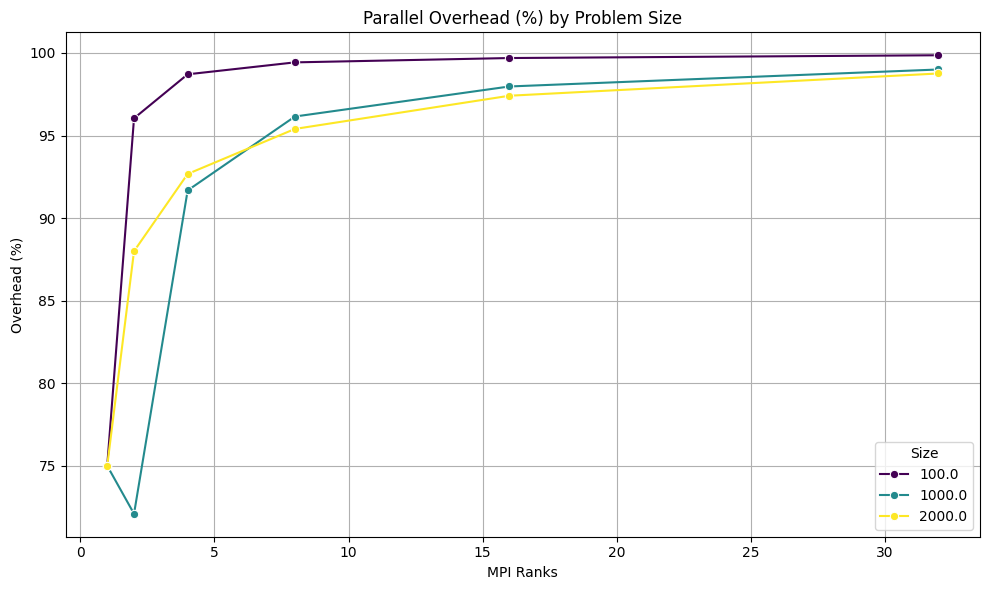

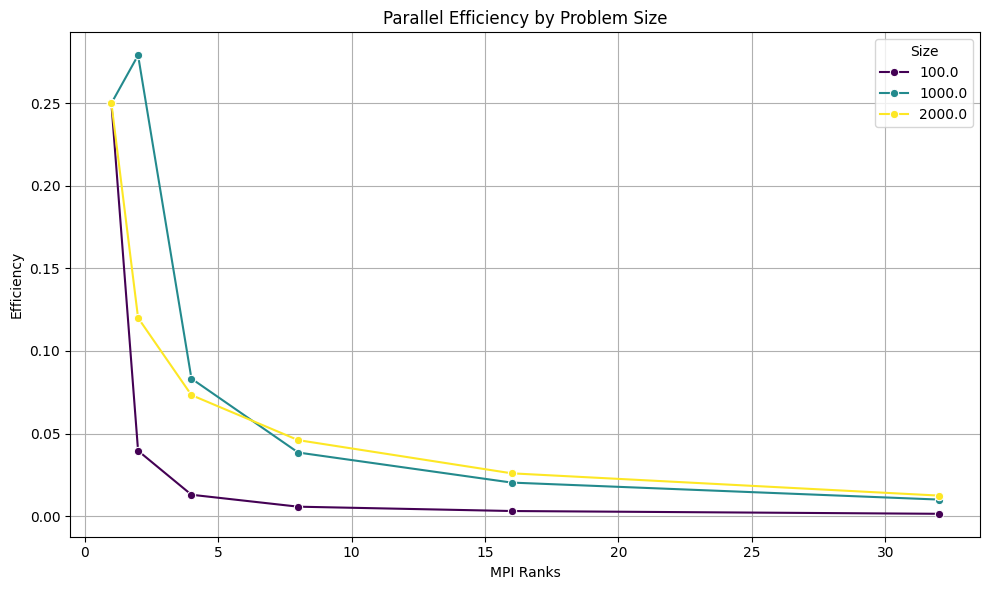

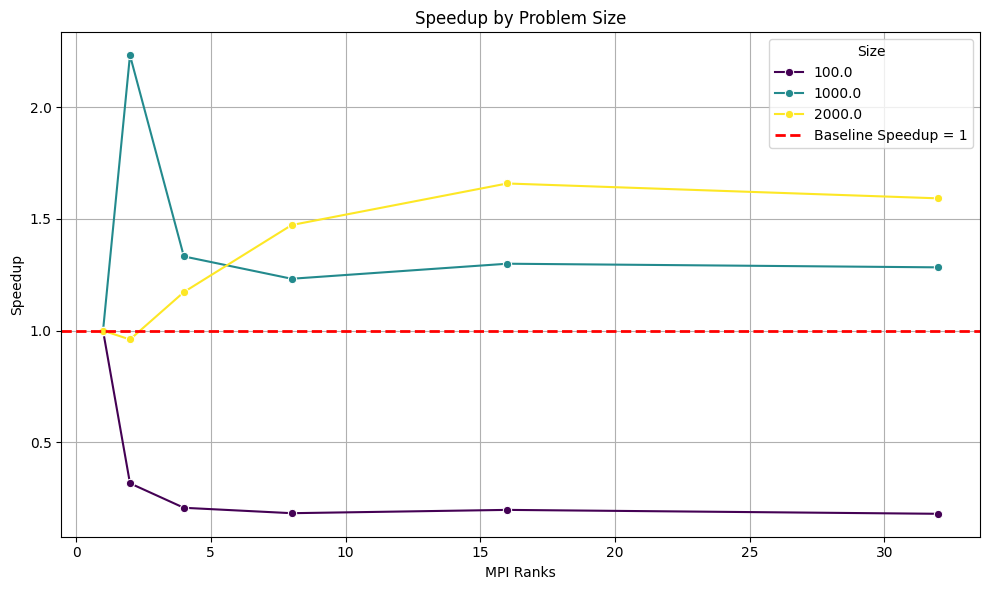

In [100]:
metrics_df = compute_metrics_by_size(mpi_df)
plot_overhead_by_size(metrics_df)
plot_efficiency_by_size(metrics_df)
plot_speedup_by_size(metrics_df)


In [96]:
metrics_df.to_csv("parallel_metrics_by_size.csv", index=False)